In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, explained_variance_score
from itertools import product
from scipy.sparse import coo_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.linalg import orthogonal_procrustes
from utils_plot import *

In [164]:
# 1. Data Normalization
def preprocessing(alpha1, alpha2, N, ampl_threshold=0.2):

    targetnames = np.array(sorted(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    #N_norm = N - np.mean(N, axis=0, keepdims=True) #We will optimize the sparse matrix, so we need to keep the absolute zero values.

    return alpha1_norm, alpha2_norm, N, targetnames_filtered, tf_names_filtered

In [165]:
# ---------- Step 1: Fit A using analytical SVD model ----------

def svd_regression_with_lambda_CV(alpha, N, lambdaA_values, n_splits=5, random_state=42):
    """
    Perform regression using SVD and select best regularization parameter (lambda)
    using k-fold Cross-Validation, following ISMARA approach.
    """
    # Get dimensions
    G, M = N.shape
    C = alpha.shape[1]
    
    # Perform SVD once
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Metrics storage
    val_errors = np.zeros((len(lambdaA_values), n_splits))
    val_explained_variances = np.zeros((len(lambdaA_values), n_splits))
    train_explained_variances = np.zeros((len(lambdaA_values), n_splits))
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(G))):
        # Prepare matrices for this fold
        U_train = U[train_idx, :]
        alpha_train = alpha[train_idx, :]
        M_train = U_train.T @ alpha_train
        
        U_val = U[val_idx, :]
        alpha_val = alpha[val_idx, :]
        
        # Test each lambda value
        for i, lambd in enumerate(lambdaA_values):
            # Calculate shrinkage factors
            shrink = s / (s**2 + lambd)
            
            # Get A_star for this lambda using training data
            A_star = VT.T @ (shrink[:, None] * M_train)
            
            # Make predictions
            R_train = N[train_idx, :] @ A_star
            R_val = N[val_idx, :] @ A_star
            
            # Calculate metrics
            val_errors[i, fold] = mean_squared_error(alpha_val.T, R_val.T)
            val_explained_variances[i, fold] = explained_variance_score(alpha_val, R_val)
            train_explained_variances[i, fold] = explained_variance_score(alpha_train, R_train)
    
    # Average metrics across folds
    mean_val_errors = np.mean(val_errors, axis=1)
    mean_val_explained_variances = np.mean(val_explained_variances, axis=1)
    mean_train_explained_variances = np.mean(train_explained_variances, axis=1)
    
    # Find optimal lambda
    best_lambda_idx = np.argmin(mean_val_errors)
    best_lambdaA = lambdaA_values[best_lambda_idx]
    
    # Train final model on all data using optimal lambda
    shrink_opt = s / (s**2 + best_lambdaA)
    M_full = U.T @ alpha
    A_star = VT.T @ (shrink_opt[:, None] * M_full)

    # Plot
    fig, ax1 = plt.subplots(figsize=(6,4))

    color = 'tab:blue'
    ax1.set_xlabel('Lambda')
    ax1.set_ylabel('Validation MSE', color=color)
    ax1.plot(lambdaA_values, mean_val_errors, color=color, label='Validation MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Explained Variance (%)')

    color = 'tab:green'
    ax2.plot(lambdaA_values, mean_val_explained_variances * 100, color='tab:green', linestyle='--', label='Validation EV')
    ax2.plot(lambdaA_values, mean_train_explained_variances * 100, color='tab:orange', linestyle='--', label='Training EV')
    ax2.tick_params(axis='y')

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

    fig.suptitle('Cross-Validation: MSE and EV vs Lambda')
    fig.tight_layout()
    plt.show()
    
    print(f"Best λ_A = {best_lambdaA:.2f}")

    return A_star, best_lambdaA

In [166]:
# ---------- Step 2: Fit W using PyTorch with fixed A_star ----------

class FitWWithFixedA(nn.Module):
    def __init__(self, N, A_star, alpha_train, lambdaW=0.01):
        super().__init__()
        # Keep only nonzero positions from N
        N_sparse = coo_matrix(N)
        self.i = torch.tensor(N_sparse.row, dtype=torch.long)
        self.j = torch.tensor(N_sparse.col, dtype=torch.long)

        self.alpha_train = torch.tensor(alpha_train, dtype=torch.float32)
        self.A_star = torch.tensor(A_star, dtype=torch.float32)

        self.num_genes, self.num_tfs = N.shape
        self.lambdaW = lambdaW

        # W only for nonzero motif entries
        self.W_sparse = nn.Parameter(torch.randn(len(self.i)) * 0.05)

    def forward(self):
        W_tensor = torch.sparse_coo_tensor(
            indices=torch.stack([self.i, self.j]),
            values=self.W_sparse,
            size=(self.num_genes, self.num_tfs)
        )
        return torch.matmul(W_tensor.to_dense(), self.A_star)

    def loss(self):
        pred = self.forward()
        mse = torch.sum((self.alpha_train - pred) ** 2)
        l1 = torch.sum(torch.abs(self.W_sparse)) #Lasso regression
        return mse + self.lambdaW * l1

In [167]:
def fit_W_given_A(N, alpha_train, alpha_test, A_star, lambdaW=0.01, lr=0.01, num_epochs=1000, patience=20):
    model = FitWWithFixedA(N, A_star, alpha_train, lambdaW=lambdaW)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_mse = float('inf')
    best_EV = -np.inf
    patience_counter = 0

    A_torch = torch.tensor(A_star, dtype=torch.float32)
    alpha_test_torch = torch.tensor(alpha_test, dtype=torch.float32)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model.loss()
        loss.backward()
        optimizer.step()

        # Eval on test
        W_tensor = torch.sparse_coo_tensor(
            indices=torch.stack([model.i, model.j]),
            values=model.W_sparse.detach(),
            size=(model.num_genes, model.num_tfs)
        )
        R_test = torch.matmul(W_tensor.to_dense(), A_torch)
        EV_test = explained_variance_score(alpha_test, R_test.detach().numpy())
        test_mse = mean_squared_error(alpha_test, R_test.detach().numpy())

        if test_mse < best_mse - 0.001:
            best_mse = test_mse
            best_EV = EV_test
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train loss: {loss.item():.2f}, Test MSE: {test_mse:.4f}, Best MSE: {best_mse:.4f}, EV_test: {EV_test*100:.2f}%")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}. Best Test EV: {best_EV*100:.2f}%, MSE: {best_mse:.4f}")
            break

    # Final W matrix
    W_final = W_tensor.to_dense().numpy()
    return W_final, best_mse

In [168]:
# 4. Cross-Validation for Lambda Optimization
def cross_val_lambda(N, alpha1, alpha2, A_star, lambdaW_values):
    best_lambdaW, best_lambdaA, best_EV = None, None, -np.inf
    losses1 = []
    losses2 = []
    EVs_avg = []

    for lambdaW in lambdaW_values:
        print(f"Testing lambdaW = {lambdaW:.5f}")

        # Train on alpha1, test on alpha2
        W1, loss1 = fit_W_given_A(N, alpha1, alpha2, A_star, lambdaW)
        losses1.append(loss1)
        R_test1 = W1 @ A_star
        EV1 = explained_variance_score(alpha2, R_test1)

        # Train on alpha2, test on alpha1
        W2, loss2 = fit_W_given_A(N, alpha2, alpha1, A_star, lambdaW)
        losses2.append(loss2)
        R_test2 = W2 @ A_star
        EV2 = explained_variance_score(alpha1, R_test2)

        avg_EV = (EV1 + EV2) / 2
        EVs_avg.append(avg_EV)
        print(f"lambdaW={lambdaW:.5f}, EV={avg_EV*100:.2f}%\n")

        if avg_EV > best_EV:
            best_lambdaW, best_EV = lambdaW, avg_EV
            
    plt.figure(figsize=(7, 5))
    plt.plot(lambdaW_values, EVs_avg)
    plt.xscale("log")
    plt.xlabel("lambdaW")
    plt.ylabel("EV Test")
    plt.grid(True)
    plt.title("EV test vs Lambda")
    plt.show()
    
    plt.figure(figsize=(7, 5))
    plt.plot(lambdaW_values, losses1)
    plt.xscale("log")
    plt.xlabel("lambdaW")
    plt.ylabel("Loss function")
    plt.grid(True)
    plt.title("Loss vs Lambda")
    plt.show()

    print(f"Best λ_W = {best_lambdaW:.5f}, Best EV={best_EV*100:.2f}%\n")
    return best_lambdaW

In [169]:
# 5. Cross train for best model
def cross_train(N, alpha1, alpha2, A_star, best_lambdaW):
    print("Training on α1, testing on α2...")
    W1, loss1 = fit_W_given_A(N, alpha1, alpha2, A_star, best_lambdaW)
    R_test1 = W1 @ A_star
    EV1_train = explained_variance_score(alpha1, R_test1)
    EV1_test = explained_variance_score(alpha2, R_test1)

    print("Training on α2, testing on α1...")
    W2, loss2 = fit_W_given_A(N, alpha2, alpha1, A_star, best_lambdaW)
    R_test2 = W2 @ A_star
    EV2_train = explained_variance_score(alpha2, R_test2)
    EV2_test = explained_variance_score(alpha1, R_test2)

    avg_EV_train = (EV1_train + EV2_train) / 2
    avg_EV_test = (EV1_test + EV2_test) / 2
    print(f"Average EV_train: {avg_EV_train*100:.2f}%")
    print(f"Average EV_test: {avg_EV_test*100:.2f}%")
    
    return W1, W2

In [170]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360) 



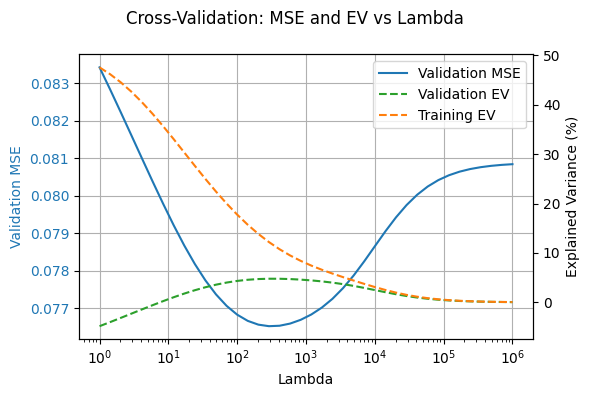

Best λ_A = 289.43


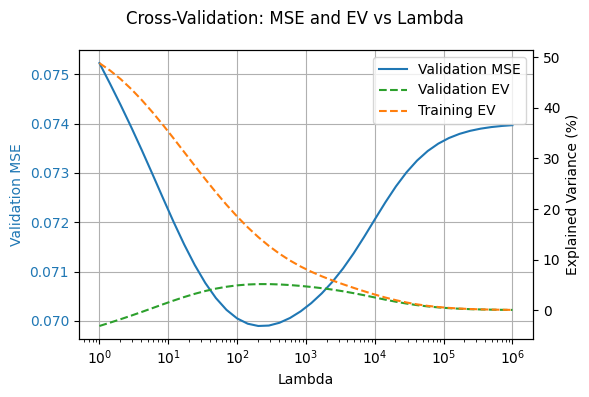

Best λ_A = 203.09
Testing lambdaW = 0.0000
Epoch 0, Train loss: 6566.18, Test MSE: 0.0737, Best MSE: 0.0737, EV_test: 0.31%
Epoch 100, Train loss: 4657.53, Test MSE: 0.0561, Best MSE: 0.0563, EV_test: 23.32%
Epoch 200, Train loss: 3503.81, Test MSE: 0.0467, Best MSE: 0.0469, EV_test: 35.79%
Early stopping at epoch 270. Best Test EV: 39.84%, MSE: 0.0438
Epoch 0, Train loss: 6005.39, Test MSE: 0.0806, Best MSE: 0.0806, EV_test: 0.34%
Epoch 100, Train loss: 4254.29, Test MSE: 0.0613, Best MSE: 0.0617, EV_test: 23.03%
Epoch 200, Train loss: 3213.35, Test MSE: 0.0507, Best MSE: 0.0512, EV_test: 35.94%
Epoch 300, Train loss: 2541.34, Test MSE: 0.0444, Best MSE: 0.0450, EV_test: 43.78%
Early stopping at epoch 308. Best Test EV: 43.02%, MSE: 0.0450
lambdaW=0.00, EV=42.72%

Testing lambdaW = 0.0001
Epoch 0, Train loss: 6572.96, Test MSE: 0.0738, Best MSE: 0.0738, EV_test: 0.21%
Epoch 100, Train loss: 4663.89, Test MSE: 0.0562, Best MSE: 0.0564, EV_test: 23.25%
Epoch 200, Train loss: 3509.88, Te

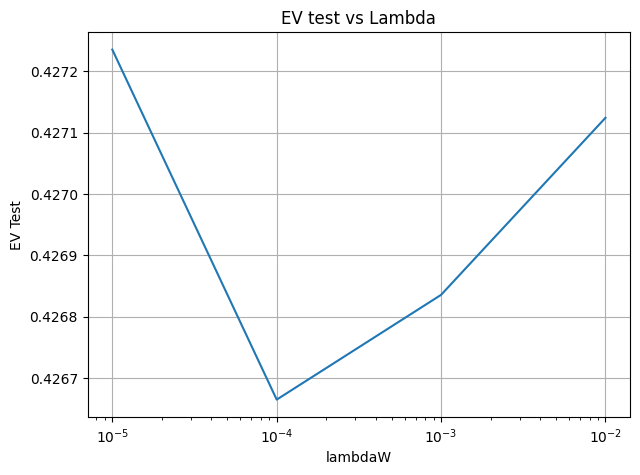

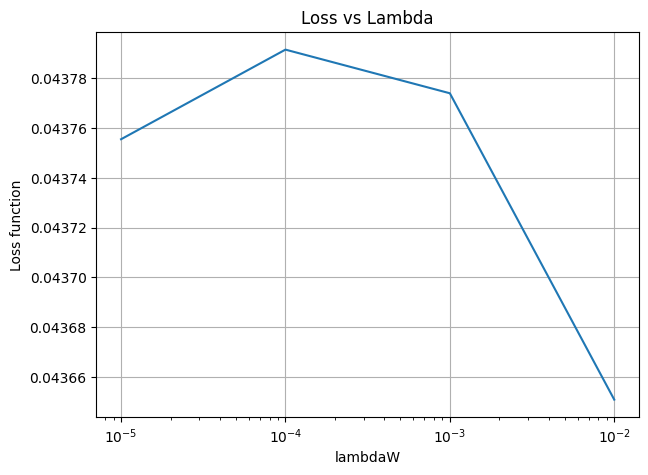

Best λ_W = 0.00001, Best EV=42.72%

Training on α1, testing on α2...
Epoch 0, Train loss: 6565.49, Test MSE: 0.0737, Best MSE: 0.0737, EV_test: 0.31%
Epoch 100, Train loss: 4656.78, Test MSE: 0.0561, Best MSE: 0.0563, EV_test: 23.33%
Epoch 200, Train loss: 3502.97, Test MSE: 0.0467, Best MSE: 0.0469, EV_test: 35.81%
Early stopping at epoch 270. Best Test EV: 39.86%, MSE: 0.0437
Training on α2, testing on α1...
Epoch 0, Train loss: 6007.18, Test MSE: 0.0806, Best MSE: 0.0806, EV_test: 0.29%
Epoch 100, Train loss: 4256.42, Test MSE: 0.0614, Best MSE: 0.0619, EV_test: 22.98%
Epoch 200, Train loss: 3215.48, Test MSE: 0.0508, Best MSE: 0.0514, EV_test: 35.90%
Epoch 300, Train loss: 2543.29, Test MSE: 0.0445, Best MSE: 0.0452, EV_test: 43.74%
Early stopping at epoch 326. Best Test EV: 44.11%, MSE: 0.0442
Average EV_train: 55.99%
Average EV_test: 43.23%


In [171]:
# Load Data & Run
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
torch.manual_seed(42)
random_state = 42

# Define Lambda Values
lambdaA_values = np.logspace(0, 6, 40)
lambdaW_values = np.logspace(-5, -2, 4)
#lambdaW_values = [0.89]
#best_lambdaW, best_lambdaA = 0.89, 0.05

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape, "\n")

# Fit A, optimize lambdaA
A_star1, best_lambdaA_1 = svd_regression_with_lambda_CV(alpha1_norm, N_norm, lambdaA_values, n_splits=5, random_state=random_state)
A_star2, best_lambdaA_2 = svd_regression_with_lambda_CV(alpha2_norm, N_norm, lambdaA_values, n_splits=5, random_state=random_state)

#Fit W using A and N
best_lambdaW = cross_val_lambda(N_norm, alpha1_norm, alpha2_norm, A_star1, lambdaW_values)

# Train and Cross-Test
W1, W2 = cross_train(N_norm, alpha1_norm, alpha2_norm, A_star1, best_lambdaW)
A1, A2 = A_star1, A_star2

# Save activities (TFs × θ)
#np.save("activities_export/A_star_pytorch.npy", A1)
#np.save("activities_export/tf_names_pytorch.npy", np.array(tf_names))
#np.save("activities_export/targetnames_pytorch.npy", np.array(targetnames))

In [172]:
print(np.sort(W1.flatten()))
print(np.sort(A1.flatten()))

[-3.8948972 -3.8692482 -3.8626962 ...  3.838379   3.8914387  3.9462795]
[-0.03356886 -0.03356714 -0.03302428 ...  0.03026564  0.03038916
  0.03048568]


In [173]:
#We smooth activities
#A1 = fourier_fit(A1, theta_smooth)
#A2 = fourier_fit(A2, theta_smooth)
R1 = W1 @ A1
R2 = W2 @ A2

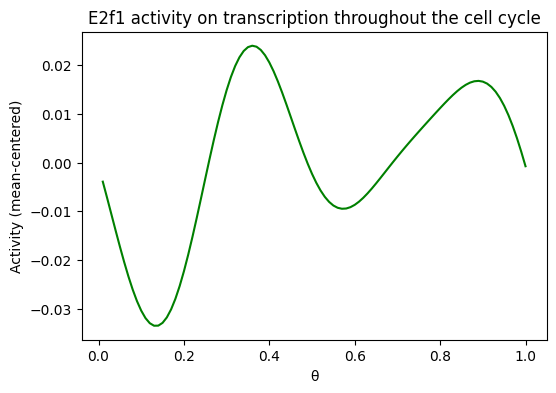

Positive W1 among target genes of E2f1 : 114/160 (71.25%)


In [183]:
BP_nb = np.where(tf_names == 'E2f1')[0][0]
#BP_nb = 30
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)
print(f"Positive W1 among target genes of {tf_names[BP_nb]} : {np.sum(W1[:, BP_nb] > 0)}/{np.sum(W1[:, BP_nb] != 0)} ({np.sum(W1[:, BP_nb] > 0)/np.sum(W1[:, BP_nb] != 0)*100:.2f}%)")

Train


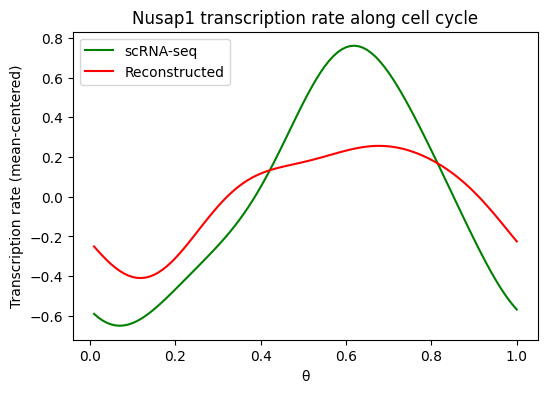

Test


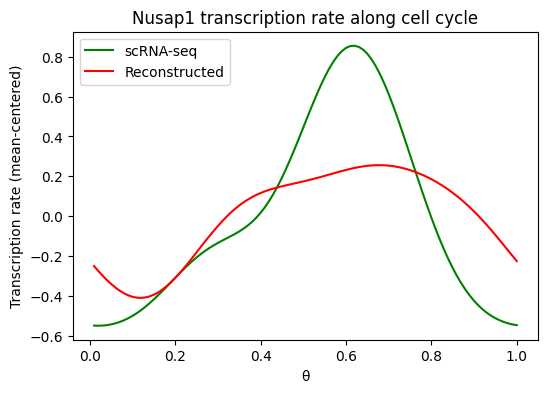

In [175]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 4972
print("Train")
plot_rate_comparison(targetnames, alpha1_norm, R1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_norm, R1, process, theta_smooth, target_nb=n)

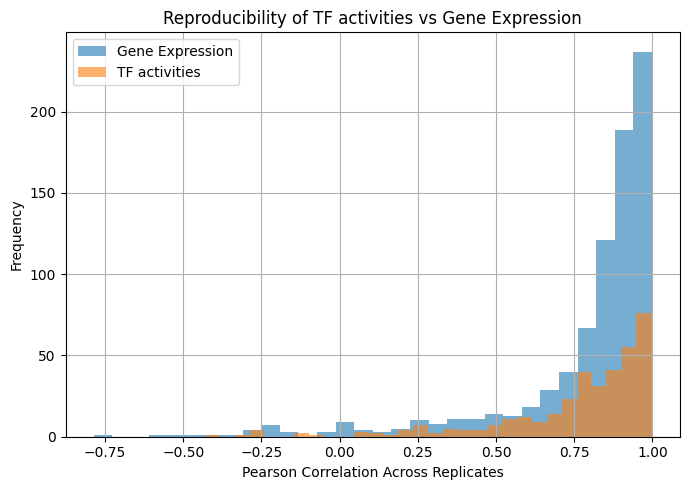

Mean correlation of expression profiles:  0.788
Mean correlation of TF activities:        0.759
Median correlation of expression:         0.886
Median correlation of TF activities:      0.836


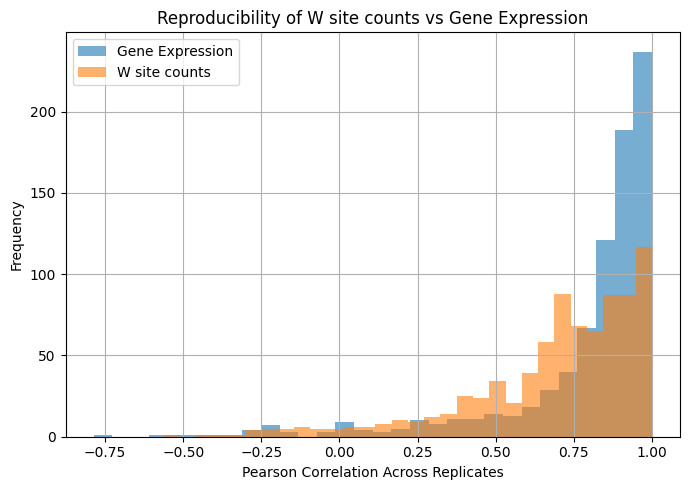

Mean correlation of expression profiles:  0.788
Mean correlation of W site counts:        0.689
Median correlation of expression:         0.886
Median correlation of W site counts:      0.756


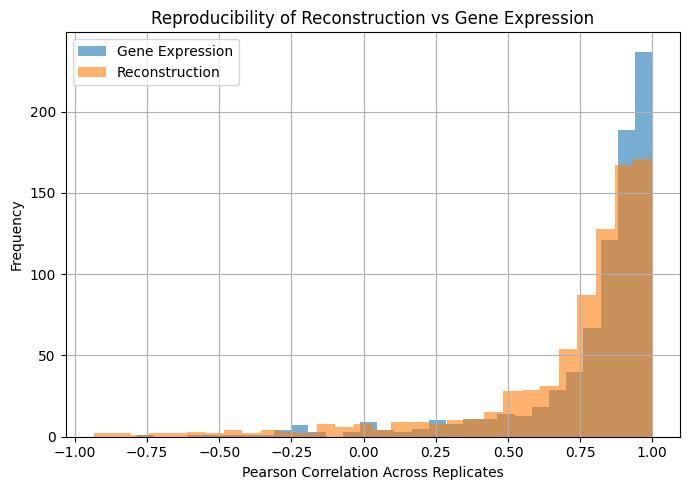

Mean correlation of expression profiles:  0.788
Mean correlation of Reconstruction:        0.718
Median correlation of expression:         0.886
Median correlation of Reconstruction:      0.836


In [176]:
corrs_A, corrs_E =  compute_reproducibility(A1, A2, alpha1_norm, alpha2_norm, metric="TF activities")
corrs_W, corrs_E = compute_reproducibility(W1, W2, alpha1_norm, alpha2_norm, metric="W site counts")
corrs_R, corrs_E = compute_reproducibility(R1, R2, alpha1_norm, alpha2_norm, metric="Reconstruction")

['Smad3' 'Sp1' 'Tfap4' 'E2f1' 'E2f2_E2f5' 'E2f8' 'E2f7' 'Elf3' 'E2f4'
 'E2f3' 'Hes1' 'Hbp1' 'E2f6']


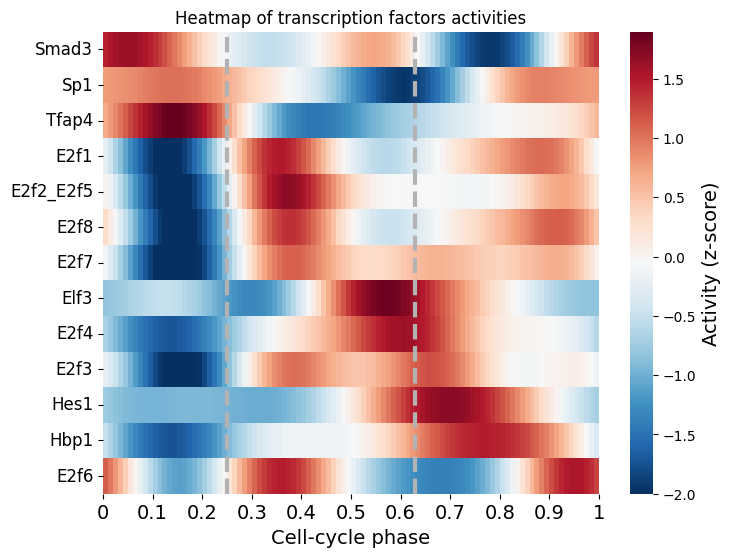

In [177]:
#Heatmap of BPs activity along cell cycle (Export)
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2_E2f5", "E2f3", "E2f4", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1", "Elf3", "Tfap4"]
tf_displayed = plot_heatmap_list(A1, tf_names, key_tfs, clip=True)
print(tf_displayed)

In [178]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [179]:
#### TF EXPRESSION AND BIOLOGICAL MEANING ####

In [180]:
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"]

fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"

#Get spliced RNA data to compare splicing and protein activity dynamics
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array([tf for tf in key_tfs if tf in alpha_sn1.index and tf in alpha_sn2.index and tf in tf_names])
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sn1_f, alpha_sn2_f = alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sn1_n, alpha_sn2_n = alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

#Standardize amplitudes
#A_standard = A_standard - np.mean(A_standard, axis=1, keepdims=True)
alpha_sn_n = (alpha_sn1_n + alpha_sn2_n) / 2
alpha_sn_norm = alpha_sn_n - np.mean(alpha_sn_n, axis=1, keepdims=True) - np.mean(alpha_sn_n, axis=0, keepdims=True) + np.mean(alpha_sn_n)
alpha_sn_norm, A_standard = standardize_amplitudes([alpha_sn_norm, A1])

TFs in common : 10/12


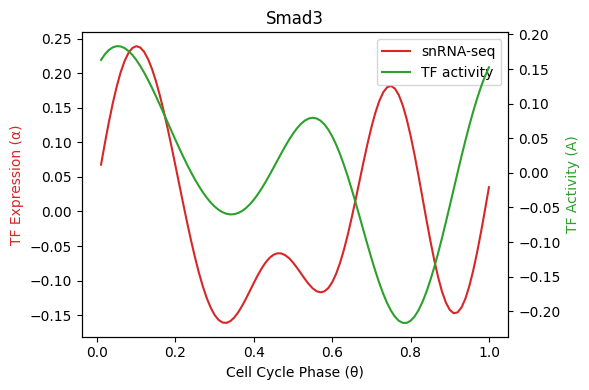

scRNA & A correlation : -0.207 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -4.82 (inhibitor)


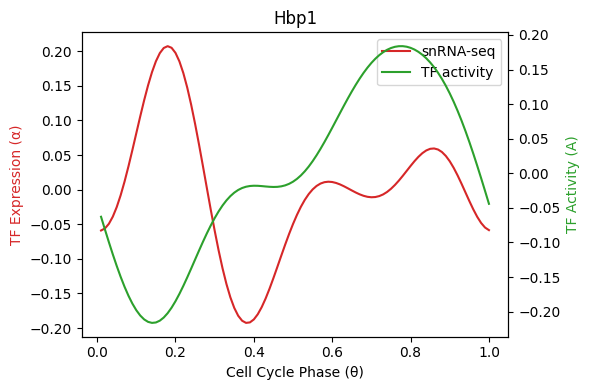

scRNA & A correlation : 0.100 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 14.89 (inhibitor)


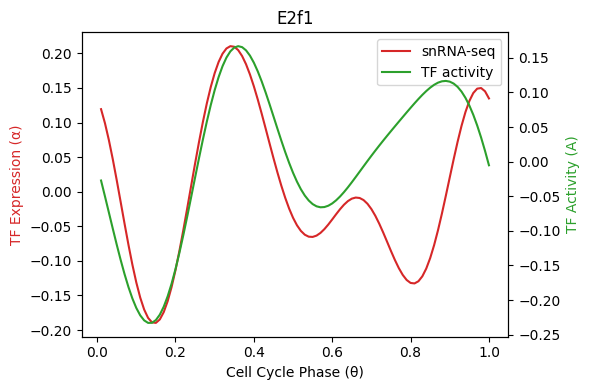

scRNA & A correlation : 0.584 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -1.91 (activator)


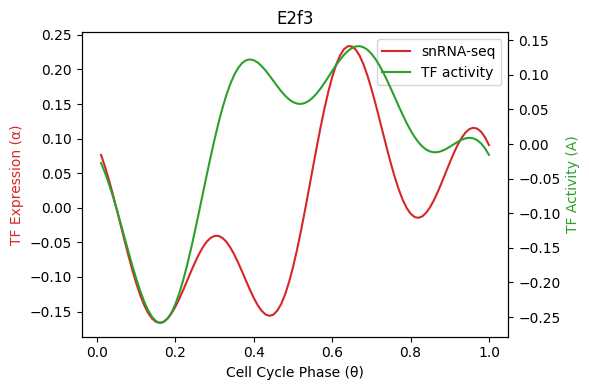

scRNA & A correlation : 0.452 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -5.84 (activator)


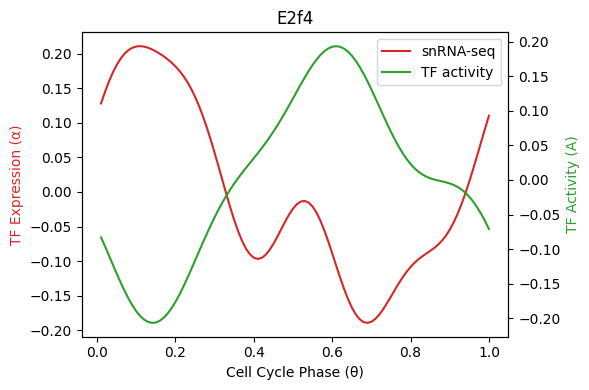

scRNA & A correlation : -0.831 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -16.00 (activator)


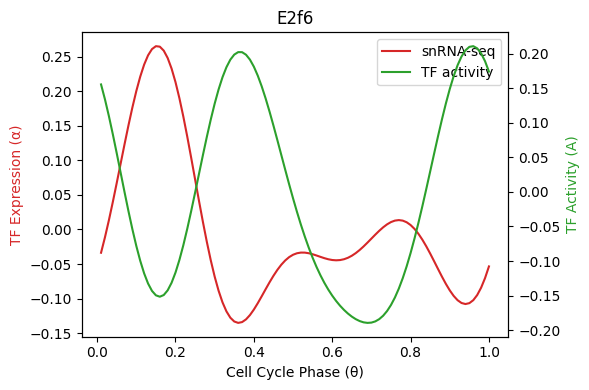

scRNA & A correlation : -0.660 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : -6.63 (activator)


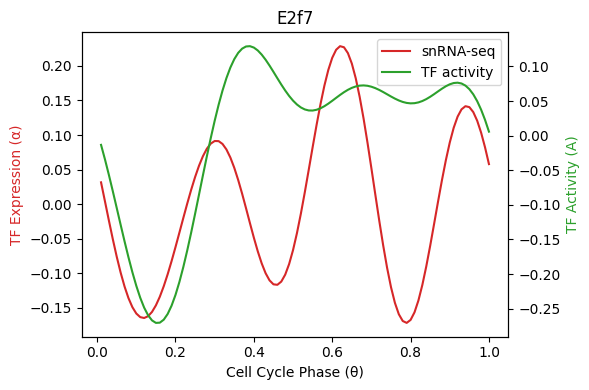

scRNA & A correlation : 0.306 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 6.66 (activator)


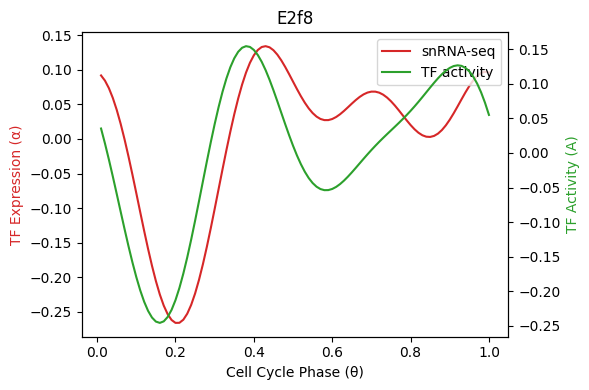

scRNA & A correlation : 0.584 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 3.05 (activator)


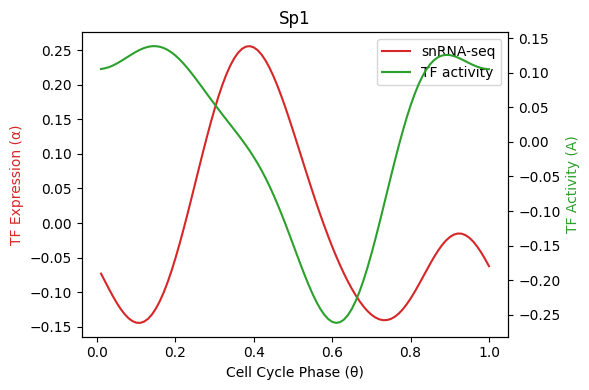

scRNA & A correlation : -0.274 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -2.14 (activator)


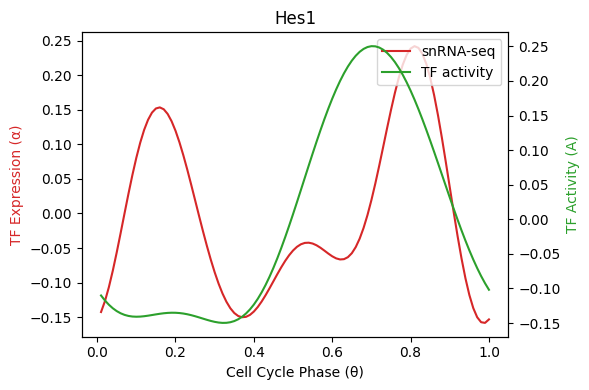

scRNA & A correlation : -0.287 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 17.69 (inhibitor)
Global correlation :-0.023
Global z-score :0.49


In [181]:
corrs = []
z_vals = []
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sn_norm, A_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sn_norm[tf], A_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    corrs.append(corr)
    z_vals.append(z_val)
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })")
print(f"Global correlation :{np.mean(corrs):.3f}")
print(f"Global z-score :{np.mean(z_vals):.2f}")